# 🏠 House Prices 이상값(outlier) 분석 실습 (문제용)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 사용해
이상값(outlier)을 탐지하고 처리(drop/clip)하는 과정을 실습하기 위한 문제집입니다.

주요 목표
1. 이상값 후보 시각화(Boxplot, Scatter)
2. IQR 기반 이상값 경계 계산
3. 이상치 행 추출/분석
4. 이상치 처리 전략 (제거 vs 클리핑)
5. 처리 전/후 데이터 분포 비교 및 해석

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("./data/05_House Prices - Advanced Regression Techniques.csv")
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 핵심 수치형 변수 살펴보기
- 아래 변수들에 대해 describe()로 기본 통계를 확인하세요.
  - SalePrice (집값)
  - LotArea (대지 면적)
  - GrLivArea (지상 생활 면적)
  - GarageArea (차고 면적)
- 어느 변수가 특히 오른쪽 꼬리가 긴(극단적으로 큰 값이 많은) 분포처럼 보이는지 적으세요.

In [6]:
# TODO: df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe().T
df[['SalePrice','LotArea','GrLivArea','GarageArea']].describe().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
GarageArea,1460.0,472.980137,213.804841,0.0,334.5,480.0,576.00,1418.0


## 문제 2️⃣: 박스플롯 & 산점도 시각화
1. `SalePrice`, `LotArea`, `GrLivArea`, `GarageArea` 각각 박스플롯(boxplot)으로 시각화하세요.
2. `GrLivArea` vs `SalePrice` 산점도를 그려서, 면적이 큰 집이 정말 비싼지/이상하게 싼지 확인하세요.

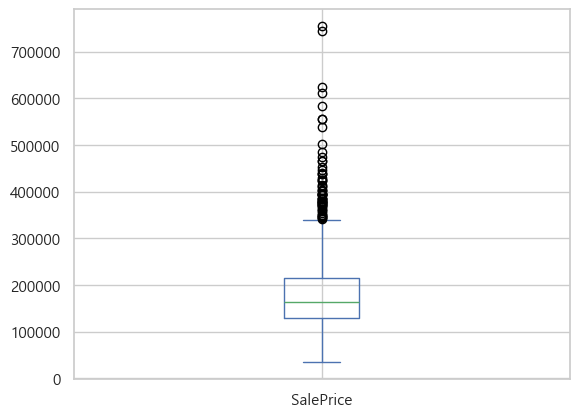

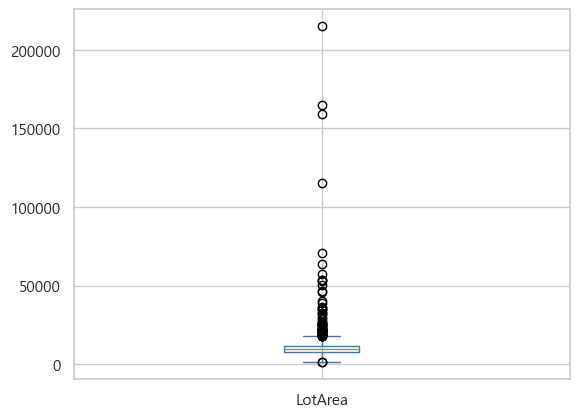

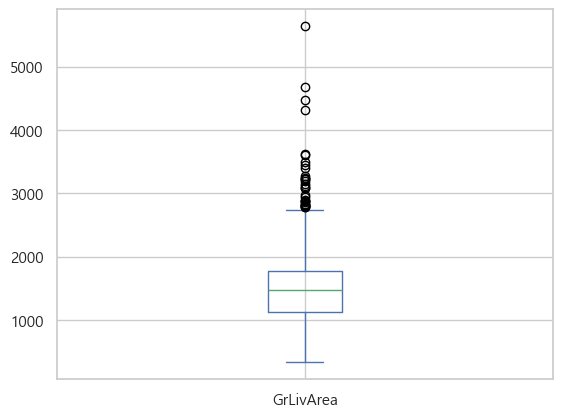

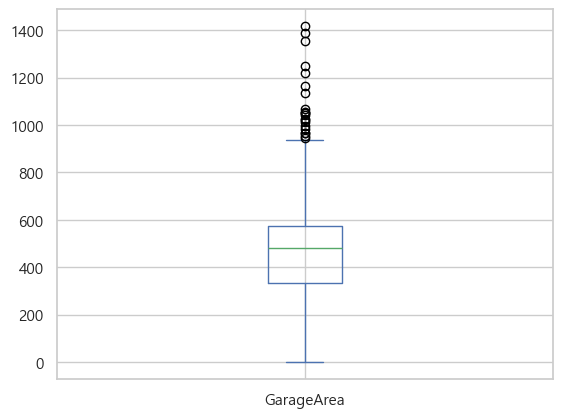

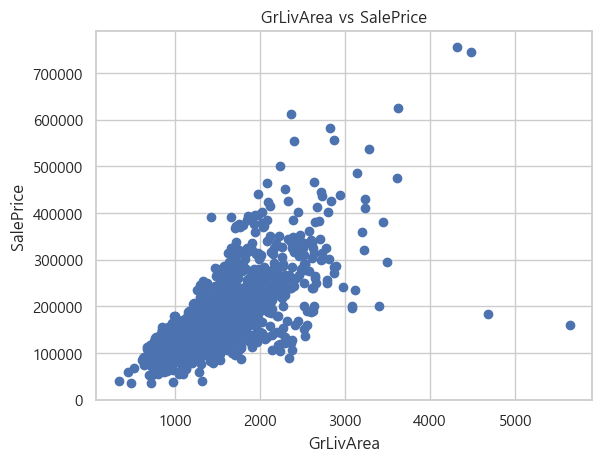

In [14]:
# TODO:
# 1) 각 컬럼별 boxplot
cols=['SalePrice', 'LotArea', 'GrLivArea', 'GarageArea']
for col in cols:
    df[col].plot(kind='box')
    plt.show()
# 2) GrLivArea vs SalePrice 산점도
plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs SalePrice')
plt.show()

## 문제 3️⃣: IQR 기반 이상값 경계 (SalePrice)
1. `SalePrice`의 Q1(25%), Q3(75%), IQR(Q3-Q1)을 구하세요.
2. IQR 방식으로 lower_bound, upper_bound를 계산하세요.
   - lower = Q1 - 1.5 * IQR
   - upper = Q3 + 1.5 * IQR
3. 이 범위를 벗어나는 행의 개수와, 전체 대비 비율(%)을 구하세요.

In [16]:
# TODO:
# Q1,Q3,IQR 계산 후 IQR 기반 하한/상한, 이상치 개수와 비율 계산
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [73]:
Q1=129975.000000
Q3=214000.000000
IQR=214000.000000-129975.000000

In [74]:
sp_lower = Q1 - 1.5 * IQR
sp_upper = Q3 + 1.5 * IQR

In [75]:
len(df[(df['SalePrice']>sp_upper)|(df['SalePrice']<sp_lower)])/len(df)

0.04178082191780822

## 문제 4️⃣: 면적 관련 이상값 탐지 (GrLivArea, LotArea)
GrLivArea와 LotArea 각각에 대해:
1. Q1, Q3, IQR 계산
2. lower_bound, upper_bound 계산
3. 경계를 벗어나는 데이터 개수 출력
4. GrLivArea 이상치들만 모아서 그들의 SalePrice를 확인하고,
   '면적은 엄청 큰데 집값은 상대적으로 안 비싼' 케이스가 있는지 살펴보세요.

In [23]:
# TODO:
# GrLivArea, LotArea에 대해 IQR 이상치 개수 계산 후
# GrLivArea 이상치 샘플들의 GrLivArea, SalePrice, OverallQual, Neighborhood를 확인
df['GrLivArea'].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

In [76]:
Q1=1129.500000
Q3=1776.750000
IQR=1776.750000-1129.500000

In [77]:
gla_lower = Q1 - 1.5 * IQR
gla_upper = Q3 + 1.5 * IQR

In [85]:
len(df[(df['GrLivArea']>gla_upper)|(df['GrLivArea']<gla_lower)])

31

In [79]:
df['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

In [80]:
Q1=7553.500000
Q3=11601.500000
IQR=11601.500000-7553.500000

In [83]:
la_lower = Q1 - 1.5 * IQR
la_upper = Q3 + 1.5 * IQR

In [84]:
len(df[(df['LotArea']>la_upper)|(df['LotArea']<la_lower)])

69

In [86]:
# GrLivArea 이상치들만 모아서 그들의 SalePrice를 확인하고, '면적은 엄청 큰데 집값은 상대적으로 안 비싼' 케이스가 있는지 살펴보세요.
df[(df['GrLivArea']>gla_upper)|(df['GrLivArea']<gla_lower)][['GrLivArea','SalePrice']]

,GrLivArea,SalePrice
58,2945,438780
118,3222,320000
185,3608,475000
197,3112,235000
231,2794,403000
304,3493,295000
324,2978,242000
496,3228,430000
523,4676,184750
583,2775,325000


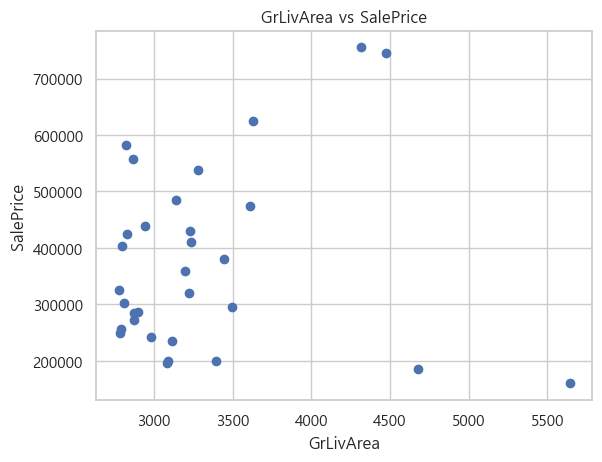

In [87]:
plt.scatter(df[(df['GrLivArea']>gla_upper)|(df['GrLivArea']<gla_lower)][['GrLivArea']],df[(df['GrLivArea']>gla_upper)|(df['GrLivArea']<gla_lower)][['SalePrice']])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs SalePrice')
plt.show()

## 문제 5️⃣: 이상치 상세 살펴보기
위에서 찾은 GrLivArea 이상치들만 따로 df_outlier_area 데이터프레임으로 저장하고
해당 샘플들의 `GrLivArea`, `SalePrice`, `OverallQual`, `Neighborhood`를 출력하세요.
이 샘플들이 특정 동네에 몰려 있는지, 품질 점수(OverallQual)가 낮은데 크기만 큰 집은 있는지 서술하세요.

In [88]:
# TODO:
# df_outlier_area를 만들고 주요 컬럼만 출력하여 특징을 관찰하세요.
df_outlier_area=df[(df['GrLivArea']>gla_upper)|(df['GrLivArea']<gla_lower)]
df_outlier_area[['GrLivArea', 'SalePrice', 'OverallQual', 'Neighborhood']]

,GrLivArea,SalePrice,OverallQual,Neighborhood
58,2945,438780,10,StoneBr
118,3222,320000,7,SawyerW
185,3608,475000,10,OldTown
197,3112,235000,8,NAmes
231,2794,403000,8,NoRidge
304,3493,295000,7,OldTown
324,2978,242000,7,NAmes
496,3228,430000,8,NoRidge
523,4676,184750,10,Edwards
583,2775,325000,10,OldTown


In [89]:
df['Neighborhood'].value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

In [90]:
df['OverallQual'].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

In [92]:
Q1=5.000000
Q3=7.000000
IQR=7.000000-5.000000

In [93]:
oq_lower=Q1-IQR
oq_upper=Q3+IQR

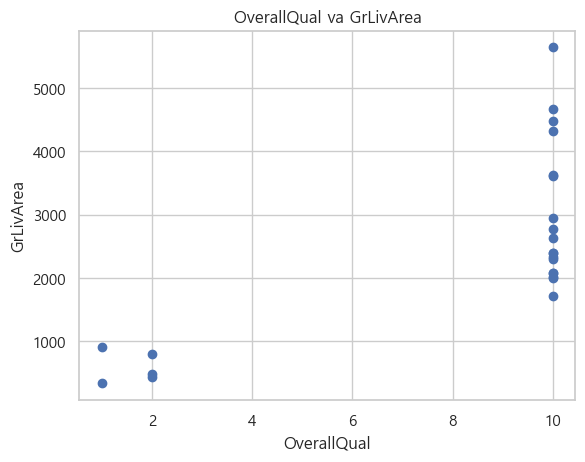

In [94]:
plt.scatter(df[(df['OverallQual']>oq_upper)|(df['OverallQual']<oq_lower)][['OverallQual']],df[(df['OverallQual']>oq_upper)|(df['OverallQual']<oq_lower)][['GrLivArea']])
plt.xlabel('OverallQual')
plt.ylabel('GrLivArea')
plt.title('OverallQual va GrLivArea')
plt.show()

## 문제 6️⃣: 이상치 처리 전략 1 - 제거(drop)
GrLivArea를 기준으로 IQR 바깥의 이상치를 제거한 새로운 DataFrame `df_clean_drop`을 만드세요.
1. 제거 전(df) vs 제거 후(df_clean_drop)의 행 수 비교
2. 두 데이터프레임 각각에서 GrLivArea의 평균, 표준편차 비교

In [95]:
# TODO:
# df_clean_drop을 만들고 행 수/평균/표준편차를 비교하세요.
df_clean_drop = df.drop(df_outlier_area.index)
df_clean_drop

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [96]:
print(len(df_clean_drop),len(df))

1429 1460


In [97]:
print(df_clean_drop.describe(),df.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1429.000000  1429.000000  1175.000000    1429.000000  1429.000000   
mean    728.710987    56.756473    69.254468   10332.004199     6.054584   
std     421.548924    42.566814    22.600163    9838.508347     1.348238   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.000000    20.000000    59.000000    7500.000000     5.000000   
50%     728.000000    50.000000    69.000000    9375.000000     6.000000   
75%    1092.000000    70.000000    80.000000   11426.000000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1429.000000  1429.000000   1429.000000  1421.000000  1429.000000  ...   
mean      5.570329  1971.316305   1984.640308    98.297678   434.392582  ...   
std       1.102639    29.951911     20.729536   169.802999   428.509207  ..

## 문제 7️⃣: 이상치 처리 전략 2 - 클리핑(윈저라이징)
1. GrLivArea의 IQR 기반 lower_bound~upper_bound를 이용해
   GrLivArea를 그 범위 안으로 `clip()` 한 DataFrame `df_clip`을 만드세요.
2. 원본 df와 df_clip 각각에 대해 GrLivArea의 boxplot을 나란히 그리고 비교하세요.
3. 제거(drop) 방식과 비교했을 때 클리핑의 장단점을 서술하세요.

In [98]:
# TODO:
# df_clip을 만들고, 원본 vs df_clip의 GrLivArea boxplot을 비교 시각화하세요.
df_clip = df.copy()
df_clip['GrLivArea'] = df_clip['GrLivArea'].clip(gla_lower, gla_upper)

In [99]:
df_clip

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## 문제 8️⃣: 이상치 처리 후 SalePrice 영향
1. 원본 df, df_clean_drop, df_clip 각각에서 SalePrice의 평균과 표준편차를 비교하세요.
2. 극단적으로 비싼 집(초고가 주택)을 어떻게 다루느냐에 따라 평균 집값이 얼마나 달라지는지 서술하세요.
3. 만약 '일반적인 중간 가격대 주택의 시세 예측'을 목표로 하는 모델이라면 어떤 버전(df / df_clean_drop / df_clip)을 쓰는 게 적절하다고 생각하나요?

In [103]:
# TODO:
# df, df_clean_drop, df_clip 각각의 SalePrice 평균/표준편차를 출력하고 해석하세요.
print('mean:',df['SalePrice'].mean(),df_clean_drop['SalePrice'].mean(),df_clip['SalePrice'].mean())
print('stv:',df['SalePrice'].std(),df_clean_drop['SalePrice'].std(),df_clip['SalePrice'].std())

mean: 180921.19589041095 176714.08817354793 180921.19589041095
stv: 79442.50288288662 71254.16981785695 79442.50288288662


## 문제 9️⃣: 다변량 관점의 이상치
1. 산점도(GrLivArea vs SalePrice)를 다시 그리되,
   - GrLivArea가 IQR 상한보다 큰데
   - SalePrice는 전체 평균보다 낮은 샘플만 다른 색(예: 빨간색)으로 표시하세요.
2. 이런 집은 어떤 의미일 수 있는지 해석을 적으세요

C:\Users\Admin\AppData\Local\Temp\ipykernel_8700\240191223.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


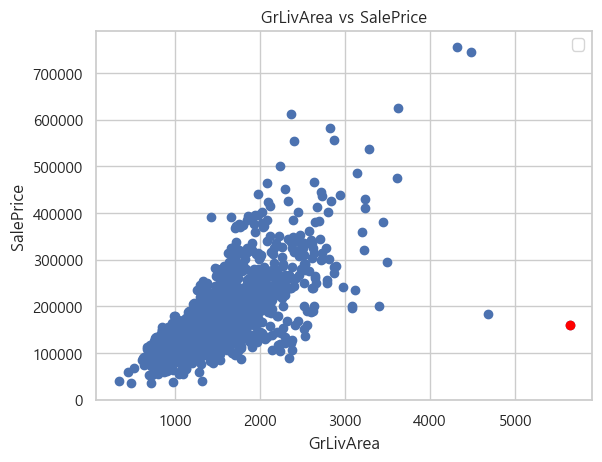

In [104]:
# TODO:
# mask_suspicious 조건에 해당하는 점들을 빨간색으로 강조 표시한 산점도를 그리세요.
price_mean = df['SalePrice'].mean()

mask = (df['GrLivArea'] > gla_upper) & (df['SalePrice'] < price_mean)

plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.scatter(df[mask]['GrLivArea'], df[mask]['SalePrice'],
            color='red')
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("GrLivArea vs SalePrice")
plt.legend()
plt.show()


## 문제 🔟: 최종 의사결정 제안서 (서술형)
우리 팀이 만들 모델이 어떤 용도인지에 따라 이상치를 다루는 방식이 달라집니다.

- '일반적인 중간 가격대 주택의 시세 예측' 모델이라면 이상치를 제거하는 게 맞나요, 클리핑이 맞나요, 아니면 그대로 두나요?
- 초고가 주택까지 정확히 예측하는 모델을 만들려면 어떤 접근이 필요할까요?
- 당신의 추천 전략을 간단히 정리하세요.

- 중간 가격대 주택의 시세 예측: drop
- 초고가 주택까지 정확히 예측: clip
